# VAE Evaluation

Notebook with eval code to sanity check and create vae reconstructions plot.

In [ ]:
import torch
import lightning as L
from torch.utils.data import DataLoader
from vae import gauss_cb_VAE, gauss_beta_VAE, gauss_ks_VAE, ks_cb_VAE, ks_beta_VAE, ks_ks_VAE, beta_cb_VAE, beta_beta_VAE, beta_ks_VAE

import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from torchvision.utils import make_grid
from einops import rearrange

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import truncnorm

from kumaraswamy import KumaraswamyStable
from vae import MNISTDataModule, CIFAR10DataModule

from torch.utils.data import DataLoader

from config import DATA_DIR, PROJECT_ROOT

In [ ]:
# load pytorch lightning model
variational_posterior = 'gaussian' # 'ks'
likelihood = 'cb' # 'cb' 'beta' 'ks'
dataset = 'mnist' #'cifar10' 'mnist'


path_to_project = PROJECT_ROOT + '/experiments/vae/'
path_to_models = path_to_project + 'trained_models/'

def load_model(variational_posterior, likelihood, dataset, path_to_models):
    model_path = path_to_models + f"{dataset}_{variational_posterior}_{likelihood}.ckpt"
    print(f"Loading: {model_path}")

    if variational_posterior == 'gaussian':
        if likelihood == 'cb':
            model_class = gauss_cb_VAE
        elif likelihood == 'beta':
            model_class = gauss_beta_VAE
        elif likelihood == 'ks':
            model_class = gauss_ks_VAE
    elif variational_posterior == 'ks':
        if likelihood == 'cb':
            model_class = ks_cb_VAE
        elif likelihood == 'beta':
            model_class = ks_beta_VAE
        elif likelihood == 'ks':
            model_class = ks_ks_VAE
    elif variational_posterior == 'beta':
        if likelihood == 'cb':
            model_class = beta_cb_VAE
        elif likelihood == 'beta':
            model_class = beta_beta_VAE
        elif likelihood == 'ks':
            model_class = beta_ks_VAE

    model = model_class.load_from_checkpoint(model_path)
    return model

model = load_model(variational_posterior, likelihood, dataset, path_to_models)

In [3]:
model.eval()
print(model.hparams, '\n\n')

"dataset":       mnist
"hidden_dim":    500
"keep_prob":     0.9
"latent_dim":    20
"learning_rate": 0.001 




In [ ]:
print(DATA_DIR)

In [5]:
if dataset == 'mnist':
    dm_class = MNISTDataModule
elif dataset == 'cifar10':
    dm_class = CIFAR10DataModule

dm = dm_class(batch_size=100, 
              clamp_extreme_pixels=(likelihood in ['beta', 'ks']), 
              data_dir=DATA_DIR, 
              num_workers=0) # must be 0 in jupyter notebook

# setup
dm.prepare_data()
dm.setup('fit')

In [6]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

In [7]:
def likelihood_mean(likelihood_params, likelihood):
    if likelihood == 'cb':
        lambda_logit = likelihood_params
        x_hat_mean = torch.distributions.ContinuousBernoulli(lambda_logit).mean
    elif likelihood == 'beta':
        alpha, beta = likelihood_params
        x_hat_mean = torch.distributions.Beta(alpha, beta).mean
    elif likelihood == 'ks':
        log_a, log_b = likelihood_params
        x_hat_mean = KumaraswamyStable(log_a, log_b).sample((100,)).mean(dim=0) # mean function numerically unstable
    
    return x_hat_mean

## Objective Evaluation

#### Compute the test elbo, test KL divergence, and test reconstruction loss


In [ ]:
train_outputs, test_outputs = [], []

for batch in train_dataloader:
    model.shared_step(batch, None, 'train', train_outputs)

for batch_idx, batch in enumerate(test_dataloader):
    model.shared_step(batch, batch_idx, 'test', test_outputs)

In [9]:
#elbo = [output['elbo'] for output in train_outputs]
#log_prob_data = [output['log_prob_data'] for output in train_outputs]
#kl = [output['kl'] for output in train_outputs]

def print_metrics(outputs, split):
    elbo = [output['elbo'] for output in outputs]
    log_prob_data = [output['log_prob_data'] for output in outputs]
    kl = [output['kl'] for output in outputs]
    print(f"** {split}: {likelihood} **")
    print('\tELBO: ', torch.stack(elbo).mean().item(), ' pm ', torch.stack(elbo).std().item())
    print('\tlog prob data: ', torch.stack(log_prob_data).mean().item(), ' pm ', torch.stack(log_prob_data).std().item())
    print('\tKL: ', torch.stack(kl).mean().item(), ' pm ', torch.stack(kl).std().item())

print(f"Dataset: {dataset}, Variational Posterior: {variational_posterior}, Likelihood: {likelihood}")
print_metrics(train_outputs, 'Train')
print_metrics(test_outputs, 'Test')

Dataset: mnist, Variational Posterior: gaussian, Likelihood: cb
** Train: cb **
	ELBO:  1858.4615478515625  pm  82.7317123413086
	log prob data:  1893.4552001953125  pm  79.65381622314453
	KL:  34.9935417175293  pm  4.429545879364014
** Test: cb **
	ELBO:  1849.825439453125  pm  90.60166931152344
	log prob data:  1884.6923828125  pm  87.4774398803711
	KL:  34.86696243286133  pm  4.496139049530029


### KNN Accuracy

In [10]:
def extract_latent_gaussian_representations(model, variational_posterior, dataloader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(x.size(0), -1)
            if variational_posterior == 'gaussian':
                mu, log_var = model.encode(x)
                latents.append(mu)
            elif variational_posterior == 'ks':
                log_a, log_b = model.encode(x)
                latents.append(KumaraswamyStable(log_a, log_b).sample((1000,)).mean(dim=0))
            else:
                raise ValueError(f"Variational posterior {variational_posterior} not supported")
            labels.append(y)
    latents = torch.cat(latents).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    return latents, labels


def compute_knn_accuracy(model, variational_posterior, train_dataloader, test_dataloader, k=15):
    L.seed_everything(0)
    train_latents, train_labels = extract_latent_gaussian_representations(model, variational_posterior, train_dataloader)
    test_latents, test_labels = extract_latent_gaussian_representations(model, variational_posterior, test_dataloader)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_latents, train_labels)
    test_preds = knn.predict(test_latents)
    
    accuracy = accuracy_score(test_labels, test_preds)
    return accuracy

In [11]:
knn_accuracy = compute_knn_accuracy(model, variational_posterior, train_dataloader, test_dataloader)
print(f'KNN {likelihood} Accuracy: {knn_accuracy}')

Seed set to 0


KNN cb Accuracy: 0.9725


## Subjective Evaluation

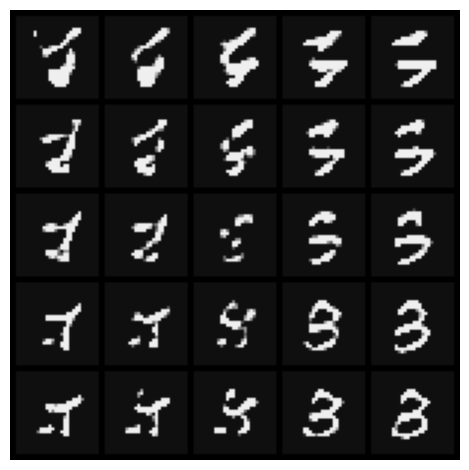

In [12]:
def generate_latent_grid(model, latent_size: int, grid_size: int, dim1: int, dim2: int, fixed_value: float = 0.0, max_z: float = 3.0) -> torch.Tensor:
    """
    Generate a grid of latent vectors by varying two specified dimensions and fixing the rest.
    """
    arr = []
    for i in range(grid_size):
        z1 = (((i / (grid_size - 1)) * max_z) * 2) - max_z
        for j in range(grid_size):
            z2 = (((j / (grid_size - 1)) * max_z) * 2) - max_z
            z = torch.tensor([fixed_value] * latent_size, device=model.device, dtype=torch.float32)
            z[dim1] = z1
            z[dim2] = z2
            likelihood_params = model.decode(z.view(1, -1))
            x_hat_mean = likelihood_mean(likelihood_params, likelihood)
        
            decoded = x_hat_mean.view(1, 1, 28, 28)
            arr.append(decoded)
    return torch.cat(arr)

def plot_latent_grid(latent_grid: torch.Tensor, grid_size: int):
    """
    Plot a grid of images from the latent space.
    """
    imgs = rearrange(make_grid(latent_grid, grid_size), "c h w -> h w c")
    imgs = imgs.cpu().detach().numpy()
    plt.imshow(imgs)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Parameters
latent_size = 20  # The latent dimension of your VAE
grid_size = int(5)     # The number of images per row/column in the grid
max_z = 4   # The range of latent space
fixed_value = 0.0

# Generate and plot the grid
latent_grid = generate_latent_grid(model, latent_size, grid_size, 0, 10, fixed_value, max_z) #grid_size, max_z)
plot_latent_grid(latent_grid, grid_size)

Seed set to 10


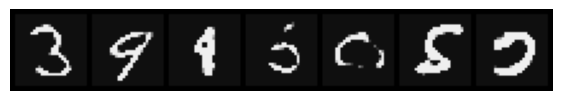

In [13]:
def sample_from_gaussian_latent_space(self, num_samples=5, seed=0):
    L.seed_everything(seed)
    self.eval()
    
    # Define the range for the truncated normal distribution
    lower, upper = -2, 2
    mean, std = 0, 1
    
    # Sample from the truncated normal distribution
    z = truncnorm.rvs(lower, upper, loc=mean, scale=std, size=(num_samples, self.hparams.latent_dim))
    z = torch.tensor(z, dtype=torch.float32).to(self.device)
    #z = torch.randn(num_samples, self.hparams.latent_dim).to(self.device)
    
    with torch.no_grad():
        likelihood_params = self.decode(z)
        x_hat_mean = likelihood_mean(likelihood_params, likelihood)

    samples = x_hat_mean.view(-1, 1, 28, 28).cpu()
    grid = vutils.make_grid(samples, nrow=num_samples, padding=2, normalize=True, value_range=(0, 1))
    plt.figure(figsize=(num_samples, 2))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def sample_from_unit_cube_latent_space(self, num_samples, seed):
    L.seed_everything(seed)
    self.eval()

    # sample from unit cube in R^{self.hparams.latent_dim}
    z = torch.rand(num_samples, self.hparams.latent_dim).to(self.device)
    z = torch.tensor(z, dtype=torch.float32).to(self.device)

    with torch.no_grad():
        likelihood_params = self.decode(z)
        x_hat_mean = likelihood_mean(likelihood_params, likelihood)
    
    samples = x_hat_mean.view(-1, 1, 28, 28).cpu()
    grid = vutils.make_grid(samples, nrow=num_samples, padding=2, normalize=True, value_range=(0, 1))
    plt.figure(figsize=(num_samples, 2))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()


sample_from_gaussian_latent_space(model, num_samples=7, seed=10)

### Viz. Latent Space in the plane

In [14]:
test_loader = DataLoader(mnist_test, batch_size=500, num_workers=0)
latents = []
labels = []

for batch in test_loader:
    x, y = batch
    x = x.view(x.size(0), -1).to(model.device)
    with torch.no_grad():
        mu, _ = model.encode(x)
        latents.append(mu.cpu().numpy())
        labels.append(y.numpy())
    
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

print('latent shape: ', latents.shape, '. labels: ', labels.shape)


NameError: name 'mnist_test' is not defined

In [ ]:
tsne = TSNE(n_components=2)
latents_2d = tsne.fit_transform(latents)

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels[:len(latents_2d)], cmap='tab10')
plt.colorbar(scatter)
plt.title('Latent Space Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Create Unified Figure Comparing reconstruction

In [15]:
dm = MNISTDataModule(batch_size=100, 
                     clamp_extreme_pixels=(likelihood in ['beta', 'ks']), 
                     data_dir=DATA_DIR, 
                     num_workers=0) # must be 0 in jupyter notebook

In [16]:
# setup
dm.prepare_data()
dm.setup('fit')
test_dataloader = dm.test_dataloader()

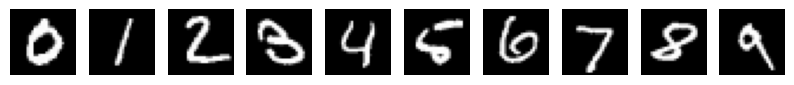

In [17]:
# iterate through test data loader and find the first instance of each digit
first_instance = {}
for batch in test_dataloader:
    x, y = batch
    for i in range(len(y)):
        if y[i].item() not in first_instance:
            first_instance[y[i].item()] = x[i]
            if len(first_instance) == 10:
                break
    if len(first_instance) == 10:
        break

# create batch of images and labels
images = torch.stack(list(first_instance.values()))
labels = torch.tensor(list(first_instance.keys()))

# sort labels by digit
_, indices = torch.sort(labels)
images = images[indices]
labels = labels[indices]

first_instance_batch = (images, labels)


# plot the first instance of each digit
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(first_instance[i].view(1, 28, 28).squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')


In [ ]:
# for each model, reconstruct the first instance of each digit
variational_posteriors = ['gaussian', 'ks']
likelihoods = ['ks', 'cb', 'beta']
images = {f'{var_post}-{likelihood}': None for var_post in variational_posteriors for likelihood in likelihoods}

for likelihood in likelihoods:
    for variational_posterior in variational_posteriors:
        model = load_model(variational_posterior, likelihood, dataset, path_to_models)
        model.eval()
        with torch.no_grad():
            x, y = first_instance_batch
            x = x.view(x.size(0), -1).to(model.device)

            clamp_pixel_values = likelihood in ['beta', 'ks']
            if clamp_pixel_values: 
                x = torch.clamp(x, .5 * (1/255), 1 - (.5 * (1/255)))

            likelihood_params, _, _ = model(x)
            x_hat_mean = likelihood_mean(likelihood_params, likelihood)
            x_hat_mean = x_hat_mean.view(len(x), 28, 28)
            images[f'{variational_posterior}_{likelihood}'] = x_hat_mean

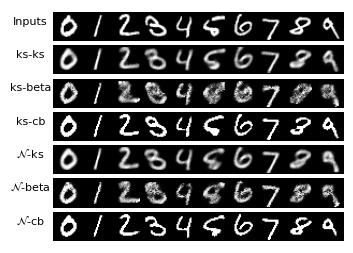

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Define the plot with GridSpec
fig = plt.figure(figsize=(3.33, 2.333))#(10, 7))
gs = gridspec.GridSpec(7, 10, wspace=0.0, hspace=0.0)

# Titles and labels for rows
row_titles = [
    "Inputs",
    "ks-ks", "ks-beta", "ks-cb",
    r"$\mathcal{N}$-ks", r"$\mathcal{N}$-beta", r"$\mathcal{N}$-cb"
]

# Add row titles
for i, title in enumerate(row_titles):
    ax = fig.add_subplot(gs[i, 0])
    ax.set_ylabel(title, rotation=0, fontsize=8, labelpad=16) # size='medium')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Plot images
for row in range(7):
    for col in range(10):
        ax = fig.add_subplot(gs[row, col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if row == 0:
            ax.imshow(first_instance_batch[0][col].cpu().numpy().reshape(28, 28), cmap='gray')
        else:
            key = row_titles[row].replace("-", "_").replace(r"$\mathcal{N}$", "gaussian").lower()
            ax.imshow(images[key][col].cpu().numpy(), cmap='gray')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.show()